In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
import json

df = pd.read_csv('data/train_data.csv')
df = df.dropna()

min_max_values = {}

scaler = MinMaxScaler()
for column in df.columns:
    if column in  ['xc_px', 'yc_px', 'xc', 'yc']:
        min_max_values[column] = (df[column].min(), df[column].max())
        df[column] = scaler.fit_transform(df[[column]])

with open('data/min_max_values.json', 'w') as f:
    json.dump(min_max_values, f)

df.head()

,x,y,z,t0,t1,t2,t3,xc_px,yc_px,xc,yc,diagonal
7,0.16,-0.19,0.12,30.100908,33.948155,75.041009,41.092854,0.012174,0.591045,0.987826,0.591045,73.389373
8,0.17,-0.18,0.12,33.363423,34.952635,76.655631,41.702995,0.031304,0.635821,0.968696,0.635821,72.801099
9,0.18,-0.17,0.12,36.636577,34.952635,76.655631,41.702995,0.057391,0.689552,0.942609,0.689552,72.780492
10,0.19,-0.16,0.12,39.899092,33.948155,75.041009,41.092854,0.081739,0.728358,0.918261,0.728358,72.835431
11,0.20,-0.15,0.12,43.130102,31.753588,71.469230,39.715641,0.104348,0.779104,0.895652,0.779104,75.239617


In [2]:
X = df[['xc_px', 'yc_px', 'xc', 'yc']].values
y = df[['t0', 't1', 't2', 't3']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. Utilizando o Mean Squared Error

In [3]:
from sklearn.metrics import mean_squared_error

mlp = MLPRegressor(max_iter=3000, random_state=42, early_stopping=True, n_iter_no_change=20)

param_dist = {
    'hidden_layer_sizes': [(300,), (100,), (100 , 50), (200,), (100, 50, 20)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

random_search = RandomizedSearchCV(mlp, param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1, verbose=3)
random_search.fit(X_train, y_train)

print("Melhores parâmetros encontrados:", random_search.best_params_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores parâmetros encontrados: {'solver': 'lbfgs', 'learning_rate_init': 0.01, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (300,), 'alpha': 0.0001, 'activation': 'logistic'}


c:\Users\rubenslima\Desktop\Faculdade\autom\mlp-robot\.auto\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [4]:
from sklearn.metrics import root_mean_squared_error as rmse

best_mlp = random_search.best_estimator_
y_pred = best_mlp.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"MSE no conjunto de teste: {mse}\nRMSE: {rmse(y_test, y_pred)}")

erro_total_geral = 0
for i in range(10):
    expected  = tuple(y_train[i])
    predicted = tuple(y_pred[i])
    
    erro_total = 0
    for n in range(len(expected)):
        print
        erro = expected[n] - predicted[n]
        print(f"t{n} : Esperado = {expected[n]:3.2f}, Obtido = {predicted[n]:3.2f}, Erro: {abs(expected[n] - predicted[n]):3.2f}")
        erro_total += abs(erro)
            
    print(f"Erro total: {erro_total:4.2f}", end="\n\n")
    erro_total_geral += erro_total

print(f"Erro total geral: {erro_total_geral:4.2f}, Média: {erro_total_geral/40:4.2f}")

MSE no conjunto de teste: 1.7504986532355509
RMSE: 1.1880139160270984
t0 : Esperado = 113.69, Obtido = 113.42, Erro: 0.27
t1 : Esperado = 27.65, Obtido = 69.59, Erro: 41.94
t2 : Esperado = 64.62, Obtido = 124.34, Erro: 59.72
t3 : Esperado = 36.97, Obtido = 54.75, Erro: 17.77
Erro total: 119.70

t0 : Esperado = 43.97, Obtido = 64.11, Erro: 20.13
t1 : Esperado = 106.98, Obtido = 106.26, Erro: 0.72
t2 : Esperado = 157.48, Obtido = 157.03, Erro: 0.45
t3 : Esperado = 50.50, Obtido = 50.79, Erro: 0.29
Erro total: 21.60

t0 : Esperado = 141.70, Obtido = 81.08, Erro: 60.62
t1 : Esperado = 100.15, Obtido = 109.72, Erro: 9.57
t2 : Esperado = 152.87, Obtido = 159.19, Erro: 6.32
t3 : Esperado = 52.73, Obtido = 49.51, Erro: 3.22
Erro total: 79.73

t0 : Esperado = 133.13, Obtido = 143.69, Erro: 10.56
t1 : Esperado = 69.97, Obtido = 94.50, Erro: 24.52
t2 : Esperado = 124.83, Obtido = 148.60, Erro: 23.76
t3 : Esperado = 54.86, Obtido = 54.11, Erro: 0.75
Erro total: 59.60

t0 : Esperado = 107.65, Obtid

In [5]:
for i in range(4):
    print(f'RMSE theta{i}: {rmse(y_test[:,i], y_pred[:,i]):.4f}')

RMSE theta0: 2.1695
RMSE theta1: 1.0683
RMSE theta2: 0.8185
RMSE theta3: 0.6957


In [6]:
teste = pd.concat([pd.DataFrame(X_test), pd.DataFrame(abs(y_pred - y_test))], axis=1)
teste.columns = ['xc_px', 'yc_px', 'xc', 'yc', 't0_diff', 't1_diff', 't2_diff', 't3_diff']
teste

,xc_px,yc_px,xc,yc,t0_diff,t1_diff,t2_diff,t3_diff
0,0.763478,0.597015,0.236522,0.597015,0.519018,1.089800,1.201629,0.109109
1,0.410435,0.429851,0.589565,0.429851,1.209971,0.721346,0.447857,0.294883
2,0.493913,0.420896,0.506087,0.420896,1.078554,0.843252,0.456773,0.420626
3,0.793043,0.143284,0.206957,0.143284,0.255332,0.502630,0.388483,0.125395
4,0.220870,0.638806,0.779130,0.638806,0.136177,0.904132,1.157809,0.222325
...,...,...,...,...,...,...,...,...
136,0.260870,0.265672,0.739130,0.265672,0.145566,0.274745,0.175850,0.054392
137,0.283478,0.644776,0.716522,0.644776,0.989672,1.140235,1.301072,0.122846
138,0.688696,0.205970,0.311304,0.205970,0.028550,0.848462,0.742775,0.131548
139,0.031304,0.594030,0.968696,0.594030,0.090566,0.087753,0.183977,0.101414


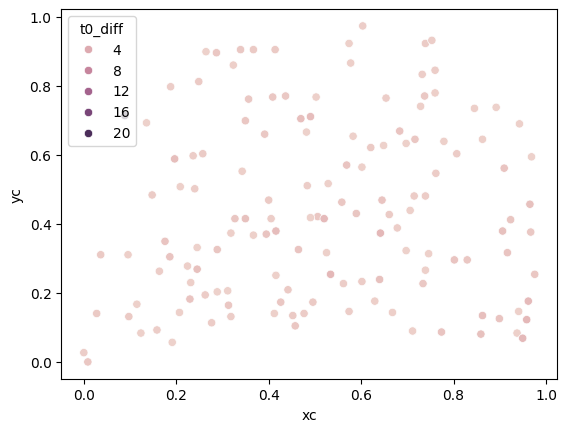

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(teste, x='xc', y='yc', hue='t0_diff')
plt.show()

In [8]:
import pickle

with open('models/mlp_base.pkl', 'wb') as f:
    pickle.dump(best_mlp, f)